In [1]:
# Standard Python modules
import os, sys
import glob
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime
import re
import textwrap

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

# extras
%matplotlib inline
import metpy.calc as mpcalc
from metpy.units import units
from scipy.ndimage import gaussian_filter    # smoothing contour lines

# import personal modules
# Path to modules
sys.path.append('../modules')
import nclcmaps as nclc
from plotter import draw_basemap

pd.options.display.float_format = "{:,.2f}".format # makes it so pandas tables display only first two decimals

ERROR 1: PROJ: proj_create_from_database: Open of /home/dnash/miniconda3/envs/SEAK-clim/share/proj failed


In [2]:
# Set up paths
path_to_data = '/data/downloaded/SCRATCH/cw3eit_scratch/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

## Load data and calculate probability

In [3]:
ensemble = 'GEFSv12'

In [4]:
## find the most recent file in the currect directory
fpath = path_to_data + 'GEFS/FullFiles/'
list_of_files = glob.glob(fpath+'*') # * means all if need specific format then *.csv
fname = max(list_of_files, key=os.path.getctime)
print(fname)

# pull the initialization date from the filename
regex = re.compile(r'\d+')
date_string = regex.findall(fname)
model_init_date = datetime.strptime(date_string[1], '%Y%m%d%H')
print(model_init_date)

hr = model_init_date.strftime('%H')
weekday = model_init_date.strftime('%a')
day = model_init_date.strftime('%-d')
month = model_init_date.strftime('%b')
year = model_init_date.strftime('%Y')

/data/downloaded/SCRATCH/cw3eit_scratch/GEFS/FullFiles/IVT_Full_2023050206.nc
2023-05-02 06:00:00


In [5]:
## load the GEFS data
ds = xr.open_dataset(fname)
ds = ds.assign_coords({"lon": (((ds.lon + 180) % 360) - 180)}) # Convert DataArray longitude coordinates from 0-359 to -180-179
ds = ds.sel(lon=slice(-180., -1)) # keep only western hemisphere
ds

<xarray.Dataset>
Dimensions:        (forecast_hour: 105, ensemble: 31, lat: 361, lon: 359)
Coordinates:
  * ensemble       (ensemble) int32 0 1 2 3 4 5 6 7 ... 23 24 25 26 27 28 29 30
  * forecast_hour  (forecast_hour) float32 0.0 3.0 6.0 9.0 ... 372.0 378.0 384.0
  * lat            (lat) float32 90.0 89.5 89.0 88.5 ... -88.5 -89.0 -89.5 -90.0
  * lon            (lon) float32 -180.0 -179.5 -179.0 -178.5 ... -2.0 -1.5 -1.0
Data variables:
    IVT            (forecast_hour, ensemble, lat, lon) float32 ...
    uIVT           (forecast_hour, ensemble, lat, lon) float32 ...
    vIVT           (forecast_hour, ensemble, lat, lon) float32 ...

In [6]:
## read text file with points
fname = '../data/latlon_coast.txt'
df = pd.read_csv(fname, header=None, sep=' ', names=['latitude', 'longitude'], engine='python')
df['longitude'] = df['longitude']*-1

In [7]:
%%time

# subset ds to the select points
lons = df['longitude'].values
lats = df['latitude'].values
x = xr.DataArray(lons, dims=['location'])
y = xr.DataArray(lats, dims=['location'])

ds = ds.sel(lon=x, lat=y, method='nearest')

## calculate probability IVT > threshold (start with 250)
threshold = 250 # kg m-1 s-1
data_size = ds.IVT.ensemble.shape

# sum the number of ensembles where IVT exceeds threshold
probability = (ds.IVT.where(ds.IVT > threshold).count(dim='ensemble')) / data_size
probability

CPU times: user 4.21 s, sys: 12.5 s, total: 16.7 s
Wall time: 16.7 s


<xarray.DataArray 'IVT' (forecast_hour: 105, location: 61)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.09677419, 0.09677419, 0.06451613, ..., 0.09677419, 0.09677419,
        0.12903226],
       [0.09677419, 0.09677419, 0.09677419, ..., 0.06451613, 0.09677419,
        0.09677419],
       [0.        , 0.03225806, 0.03225806, ..., 0.03225806, 0.03225806,
        0.        ]])
Coordinates:
  * forecast_hour  (forecast_hour) float32 0.0 3.0 6.0 9.0 ... 372.0 378.0 384.0
    lat            (location) float32 55.0 54.5 54.0 53.5 ... 26.0 25.5 25.0
    lon            (location) float32 -130.0 -130.0 -130.0 ... -112.0 -112.0
Dimensions without coordinates: location

## Create plot

In [8]:
# Set up projection
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

## Set up extent of plot at gridlines
lonmin = lons.min()-5.
lonmax = lons.max()+5.
latmin = lats.min()
latmax = lats.max()

ext = [lonmin, lonmax, latmin, latmax] # extent of map plot
du = 5 # how frequent for ticks
dx = np.arange(lonmin,lonmax+du,du)
dy = np.arange(latmin,latmax+du,du)

# Points to plot on map
xs = lons
ys = lats

## format dicts
kw_ticklabels = {'size': 8, 'color': 'gray', 'fontweight': 'light'}
kw_grid = {'linewidth': .5, 'color': 'k', 'linestyle': '--', 'alpha': 0.1}
kw_ticks = {'length': 4, 'width': 0.5, 'pad': 2, 'color': 'black'}

IVT_units = 'kg m$^{-1}$ s$^{-1}$'

Text(1.0, 1.0, 'Forecasts support FIRO/CA-AR Program\nIntended for research purposes only')

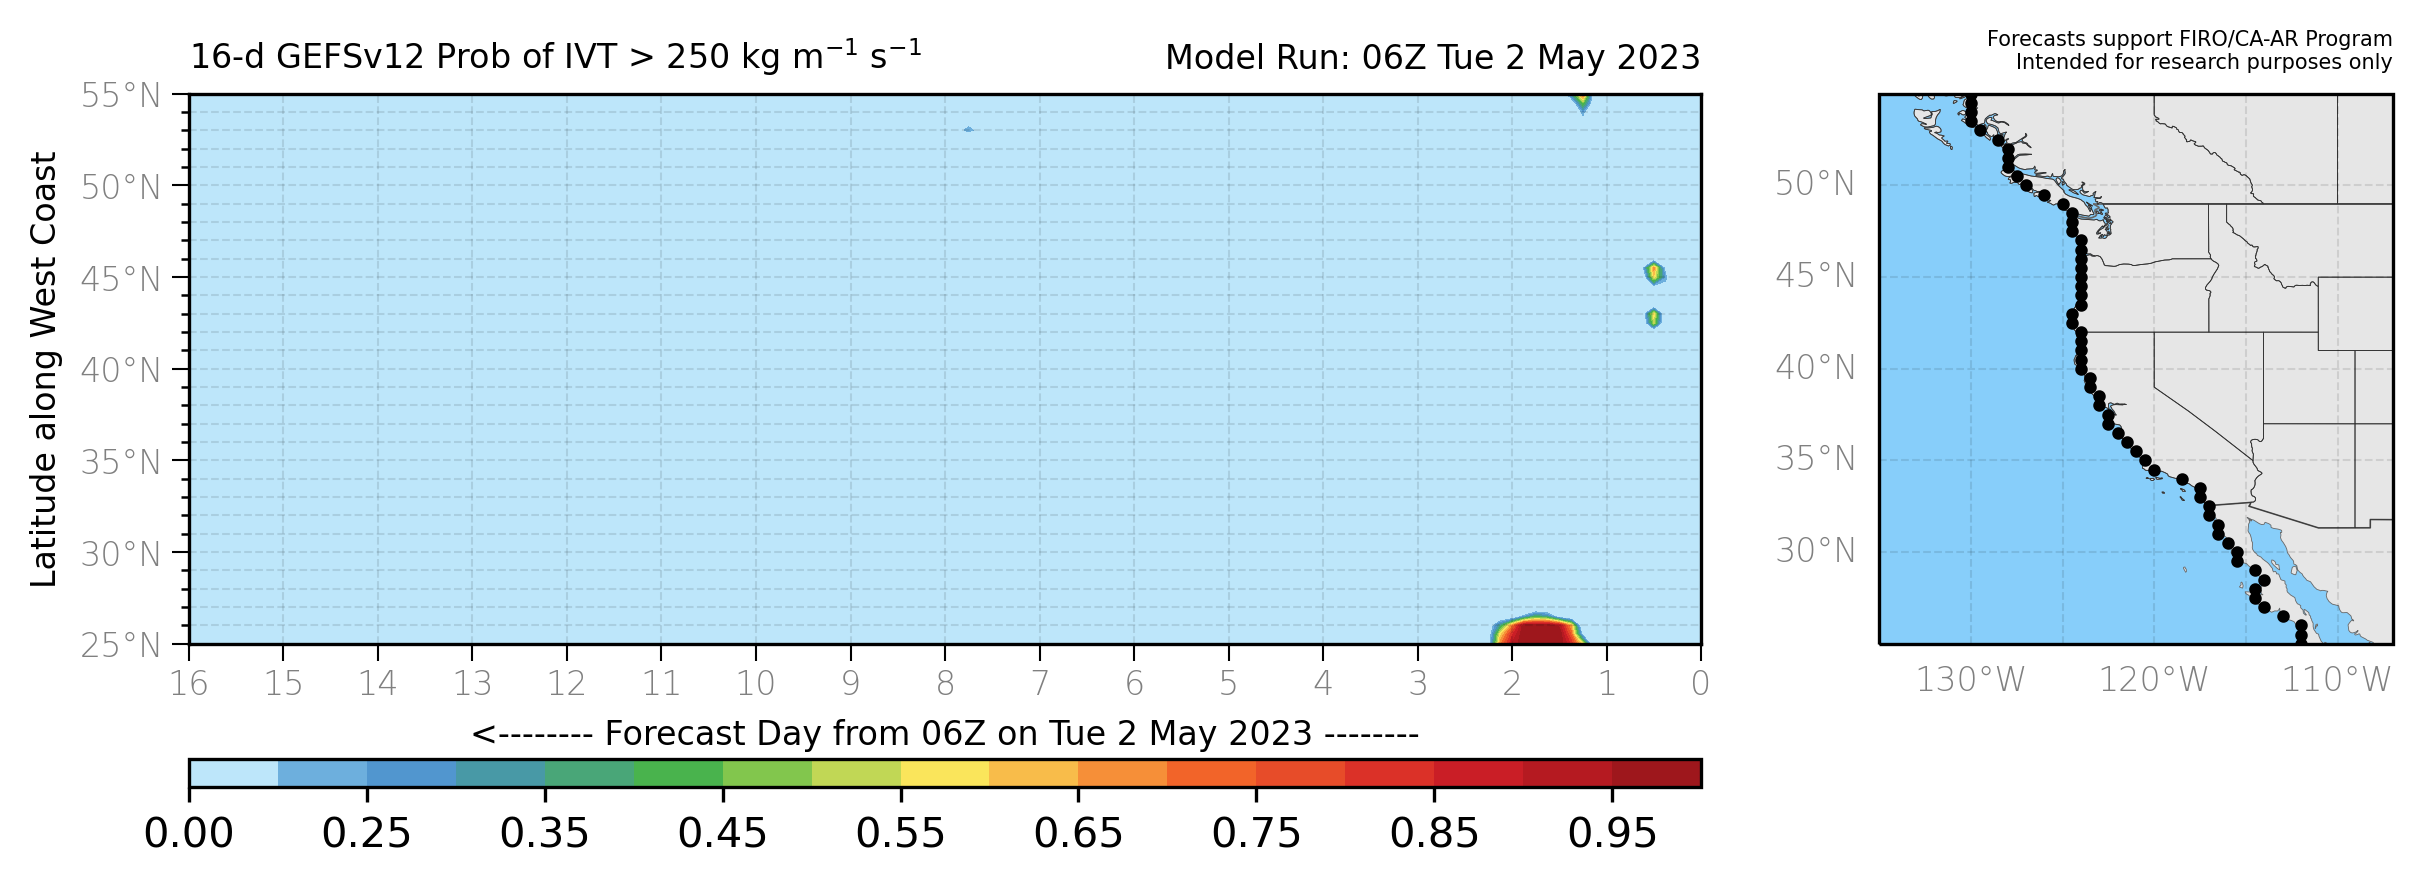

In [9]:
fig = plt.figure(figsize=(10, 3))
fig.dpi = 300
fname = path_to_figs + 'waterfall_test'
fmt = 'png'

nrows = 2
ncols = 2

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 0.05], width_ratios = [2, 1], wspace=0.05, hspace=0.4)
## use gs[rows index, columns index] to access grids

###################
### PROBABILITY ###
###################

ax = fig.add_subplot(gs[0, 0])

# Contour Filled
x = probability.forecast_hour /24 # convert forecast hour to forecast day
y = probability.lat
data = np.flipud(np.rot90(probability.values)) # rotate data 90 degrees and flip up down
cflevs = np.arange(0., 1.05, 0.05) # levels for IVT probability
indices = np.where((cflevs == 0.05) | (cflevs == 0.1) | (cflevs == 0.15000000000000002)) # hack to remove lower levels
cflevs = np.delete(cflevs, indices)
cmap = nclc.cmap('WhiteBlueGreenYellowRed') # cmap for IVT probability
cf = ax.contourf(x, y, data, levels=cflevs, cmap=cmap, extend='neither')
ax.invert_xaxis() # invert x-axis so that time reads from right to left

# apply ytick parameters
ticks_loc = ax.get_yticks().tolist()
ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax.set_yticklabels([u"{:0.0f}\N{DEGREE SIGN}N".format(x) for x in ticks_loc], **kw_ticklabels)
# apply xtick parameters
ax.xaxis.set_major_locator(mticker.MaxNLocator(16))
ticks_loc = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax.set_xticklabels([u"{:0.0f}".format(x) for x in ticks_loc], **kw_ticklabels)

# apply gridlines
ax.minorticks_on()
ax.grid(visible=None, which='both', axis='y', **kw_grid)
ax.grid(visible=None, which='major', axis='x', **kw_grid)
ax.tick_params(axis='x', which='minor', bottom=False)
ax.tick_params(axis='x', which='major', **kw_ticks)
ax.tick_params(axis='y', which='major', direction='out', **kw_ticks)

## labels and subtitles
ax.set_ylabel("Latitude along West Coast", fontsize=8)
ax.set_xlabel("<-------- Forecast Day from {0}Z on {1} {2} {3} {4} --------".format(hr, weekday, day, month, year), fontsize=8)
ax.set_title('Model Run: {0}Z {1} {2} {3} {4}'.format(hr, weekday, day, month, year), loc='right', fontsize=8)
ax.set_title('16-d {0} Prob of IVT > {1} {2}'.format(ensemble, threshold, IVT_units), loc='left', fontsize=8)

# Add color bar
cbax = plt.subplot(gs[1,0]) # colorbar axis
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal', ticklocation = 'bottom', ticks=cflevs[::2])
# cb.set_label('IVT (kg m$^{-1}$ s$^{-1}$)', fontsize=11)
# cb.ax.tick_params(labelsize=12)


###########
### MAP ###
###########

ax = fig.add_subplot(gs[0, 1], projection=mapcrs)
ax.set_extent(ext, crs=datacrs)

# Add map features (continents and country borders)
ax.add_feature(cfeature.LAND, facecolor='0.9')      
ax.add_feature(cfeature.BORDERS, edgecolor='0.4', linewidth=0.4)
ax.add_feature(cfeature.STATES, edgecolor='0.2', linewidth=0.2)
ax.add_feature(cfeature.OCEAN, edgecolor='0.4', facecolor='lightskyblue', linewidth=0.2)

# apply tick parameters   
gl = ax.gridlines(crs=datacrs, draw_labels=True, **kw_grid)
gl.top_labels = False
gl.left_labels = True
gl.right_labels = False
gl.bottom_labels = True
gl.xlocator = mticker.FixedLocator(dx)
gl.ylocator = mticker.FixedLocator(dy)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = kw_ticklabels
gl.ylabel_style = kw_ticklabels

gl.xlines = True
gl.ylines = True

# ax.tick_params(axis='y', direction='inout', labelsize=10, 
#                length=4, width=2, pad=2, color='black')




# # Contour Filled
# cf = ax.contourf(lons, lats, ivt, transform=datacrs,
#                  levels=cflevs, cmap=cmap, alpha=0.9, extend='max')

## plot point locations
for i, (x, y) in enumerate(zip(xs, ys)):
    ax.plot(x, y, 'ko', markersize=2, transform=datacrs)
    
## plot labels
label = 'Forecasts support FIRO/CA-AR Program Intended for research purposes only'
ax.set_title(textwrap.fill(label, 36), loc='right', fontsize=5)

In [ ]:
## function for basemap with points loaded

## function for portrait diagram